In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
def standardization(x):
    z = (x - min(x))/(max(x) - min(x))
    return(z)

In [29]:
def aggdata(b='_total', out='data', export=False):
    # data is from https://github.com/dongmeic/BikeCounting/blob/main/BikeCounts/Explore_Bikes_On_Buses.ipynb
    data = pd.read_csv('T:/Tableau/tableauBikesOnBuses/Datasources/AggregatedBikesOnBuses' + b + '.csv')
    aggdata = data.groupby("Location").agg({"Counts": "mean", "Growth": lambda x: x.dropna().mean()})
    aggdata = {'Location':aggdata.index.values,
               'Counts':aggdata.Counts.values,
               'Growth':aggdata.Growth.values}
    aggdata = pd.DataFrame(aggdata)
    locdata = data[['Location', 'Latitude', 'Longitude', 'Route']].drop_duplicates(ignore_index=True)
    outdata = locdata.merge(aggdata, how='inner', on='Location')
    gdf = gpd.GeoDataFrame(outdata, geometry=gpd.points_from_xy(outdata.Longitude, outdata.Latitude))
    gdf = gdf.set_crs("EPSG:4326")
    gdf = gdf.to_crs("EPSG:3857")
    
    if out == 'data':
        return(data)
    else:
        if export:
            if b == '_total':
                gdf.to_file(fr"T:\MPO\Bike&Ped\BikeCounting\StoryMap\BikeOnBuses\Output\Bikes_on_Buses.shp")
            else:
                gdf.to_file(fr"T:\MPO\Bike&Ped\BikeCounting\StoryMap\BikeOnBuses\Output\Bikes_on_Buses{b}.shp")
        return(gdf)

In [30]:
data = aggdata()

In [31]:
data.Year.unique()

array([2015, 2016, 2017, 2019, 2013, 2022, 2014, 2020, 2018, 2021],
      dtype=int64)

In [32]:
data[data.Location.isin(data.Location.values[0:4])]

,Location,Year,Counts,Latitude,Longitude,Growth,Route
0,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2015,10,44.135869,-122.613404,-0.166667,91
1,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2016,3,44.135869,-122.613404,-0.700000,91
2,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2017,21,44.135869,-122.613404,6.000000,91
3,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2019,3,44.135869,-122.613404,-0.500000,91
4,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2013,10,44.135869,-122.613404,NaN,91
5,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2022,2,44.135869,-122.613404,0.500000,91
6,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2014,12,44.135869,-122.613404,0.200000,91
7,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2020,1,44.135869,-122.613404,-0.666667,91
8,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2018,6,44.135869,-122.613404,-0.714286,91


In [33]:
data[data.Year==2013]

,Location,Year,Counts,Latitude,Longitude,Growth,Route
4,(^) N/S of Hwy 126 (MP 23.8) W of Leaburg Dam,2013,10,44.135869,-122.613404,NaN,91
16,(^) N/S of Lost Crk (Dexter),2013,53,43.914832,-122.812855,NaN,92
22,(^) S/S of Lost Crk (Dexter),2013,14,43.914660,-122.812502,NaN,92
39,(RRS) E/S River Rd N of River Ave (NE),2013,1372,44.096173,-123.126966,NaN,52
40,(RRS) E/S River Rd N of River Ave (NE),2013,1372,44.096173,-123.126966,NaN,51
...,...,...,...,...,...,...,...
15906,W/S of Willamette S of 29th,2013,62,44.025703,-123.090799,NaN,24
15922,W/S of Willamette S of 36th,2013,3,44.016119,-123.092550,NaN,73
15936,W/S of Wilshire N of Windsor Circle,2013,1,44.030492,-123.147714,NaN,78
15937,W/S of Wilshire N of Windsor Circle,2013,1,44.030492,-123.147714,NaN,76


In [34]:
data.Growth.dropna().mean()

0.2900908791930446

In [12]:
MPOBound = gpd.read_file("X:/Data/Transportation/MPO_Bound.shp")

In [35]:
gdf = aggdata(out='gdf', export=True)

In [36]:
ngdf = gdf[~gdf["Location"].str.contains('|'.join(["Springfield Station", "Eugene Station"]))]

In [45]:
outpath = r'T:\MPO\Bike&Ped\BikeCounting\StoryMap\BikeOnBuses\Output'

In [37]:
ngdf.to_file(fr"{outpath}\Bikes_on_Buses_excluded.shp")

In [38]:
values = standardization(gdf.Counts) * 1000

In [24]:
MPOBound

,Area,inside_mpo,is_in_mpo,geometry
0,125.303,Y,1,"POLYGON ((-13702033.591 5490268.024, -13700318..."


In [39]:
pip = gdf.within(MPOBound.loc[0, 'geometry'])

In [40]:
pnts = gdf.loc[pip].copy()

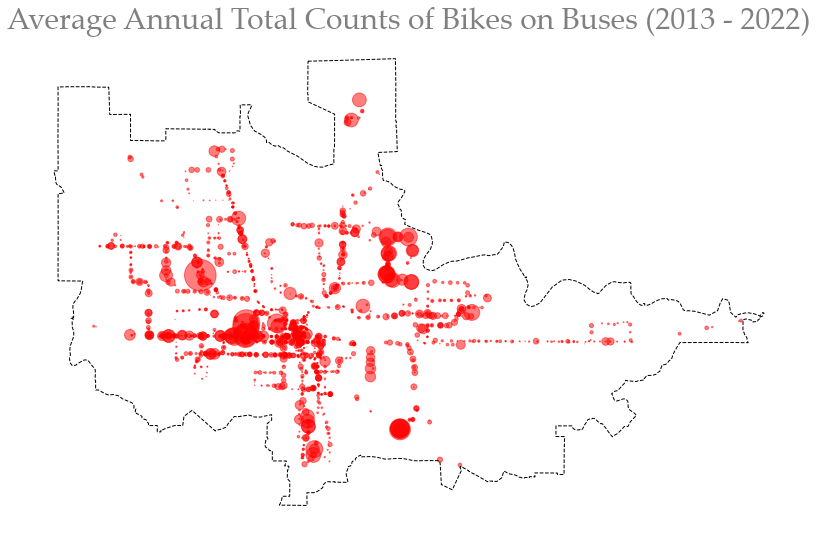

In [41]:
fig, ax = plt.subplots(figsize=(14, 12))
pnts.plot(ax=ax, marker='o', markersize=values, color='red', alpha=.5, legend=True, aspect=1)
MPOBound.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', aspect=1)
#ctx.add_basemap(ax)
plt.title("Average Annual Total Counts of Bikes on Buses (2013 - 2022)", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [42]:
gdf = aggdata(b='_inbound', out='gdf', export=True)

In [43]:
ngdf = gdf[~gdf["Location"].str.contains('|'.join(["Springfield Station", "Eugene Station"]))]

In [46]:
ngdf.to_file(fr"{outpath}\Bikes_on_Buses_inbound_excluded.shp")

In [47]:
gdf = aggdata(b='_outbound', out='gdf', export=True)

In [48]:
ngdf = gdf[~gdf["Location"].str.contains('|'.join(["Springfield Station", "Eugene Station"]))]

In [49]:
ngdf.to_file(fr"{outpath}\Bikes_on_Buses_outbound_excluded.shp")

In [50]:
ngdf.head()

,Location,Latitude,Longitude,Route,Counts,Growth,geometry
0,(^) S/S of Hwy 58 E of Pleasant Hill,43.969440,-122.938802,92,1.000000,0.000000,POINT (-13685484.837 5460714.170)
1,(^) S/S of Lost Crk (Dexter),43.914660,-122.812502,92,4.875000,1.020408,POINT (-13671425.186 5452245.106)
2,(RRS) E/S River Rd N of River Ave (on-street),44.096038,-123.128015,51,160.900000,-0.155670,POINT (-13706547.932 5480316.333)
3,(RRS) E/S River Rd N of River Ave (on-street),44.096038,-123.128015,52,160.900000,-0.155670,POINT (-13706547.932 5480316.333)
4,(RRS) E/S River Rd N of River Ave (SE),44.096072,-123.126967,55,37.666667,0.179137,POINT (-13706431.269 5480321.603)
